# Stack Overflow Multilabel Classification

In [47]:
import matplotlib.pyplot as plt
import os
import re
import string
import tensorflow as tf

from pathlib import Path
from tensorflow.keras import layers, losses
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

# Multilabel Classification (Dataset: StackOverflow)

## Dataset Fetch

In [48]:
dataset_url = "https://storage.googleapis.com/iobruno/datasets/stack_overflow_16k_pt-br.zip"

In [49]:
datasets_dir = Path(os.path.abspath('')).parent.joinpath('datasets')
datasets_dir.mkdir(parents=True, exist_ok=True)

In [50]:
dataset = tf.keras.utils.get_file(fname="stack_overflow_16k_pt-br.zip", 
                                  origin=dataset_url,
                                  extract=True,
                                  cache_dir=datasets_dir,
                                  cache_subdir='')

12345344/12337440 [==============================] - 0s 0us/step


In [51]:
so_dataset_dir = datasets_dir.joinpath("stack_overflow_16k")

In [52]:
so_train_dataset = so_dataset_dir.joinpath("train")
so_test_dataset = so_dataset_dir.joinpath("test")

In [53]:
os.listdir(so_train_dataset)

['python', 'java', 'csharp', 'javascript']

## Dataset Load

In [54]:
"""
Loads the Dataset in Batches/Lists of 32 entries each,
meaning that each iteration over the dataset will return 32 reviews
"""
batch_size = 32
seed = 42

### Loading Training Dataset

In [55]:
raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    directory=so_train_dataset,
    batch_size=batch_size,
    seed=seed,
    validation_split=0.2,
    subset='training'
)

Found 8000 files belonging to 4 classes.
Using 6400 files for training.


### Analysis of the Training Dataset

In [56]:
raw_train_ds.class_names

['csharp', 'java', 'javascript', 'python']

In [57]:
for t_corpus, t_label in raw_train_ds.take(1):
    for i in range(5):
        label  = t_label.numpy()[i]
        class_name = raw_train_ds.class_names[label]
        corpus = t_corpus.numpy()[i]
        print(f"Class Label: {label} ({class_name})")
        print(f"Review: {corpus}")
        print()

Class Label: 1 (java)
Review: b'"Como fazer a impressora Bematech MP-4200 TH (n\xc3\xa3o-fiscal) cortar o papel ao final da impress\xc3\xa3o em uma aplica\xc3\xa7\xc3\xa3o Java?\r\n"'

Class Label: 3 (python)
Review: b'"Eu tenho esta String:\r\n\r\nstr = "Eu sou uma string {dentro de uma string {dentro de outra} }"\r\n\r\n\r\nQual a express\xc3\xa3o regular que eu posso usar para conseguir apenas:\r\n\r\ndentro de uma string {dentro de outra} \r\n\r\n"'

Class Label: 1 (java)
Review: b'"Tenho um projeto Java multi-m\xc3\xb3dulo com Maven.\r\n\r\nAtualmente, controlo a vers\xc3\xa3o de cada m\xc3\xb3dulo manualmente, editando o elemento <version> do pom.xml de cada m\xc3\xb3dulo que sofre atualiza\xc3\xa7\xc3\xb5es.\r\n\r\nAcredito que este n\xc3\xa3o seja o m\xc3\xa9todo correto/indicado. Existe algo automatizado para isto?\r\n"'

Class Label: 0 (csharp)
Review: b'"Estou implementando em C# uma Consulta de Empresa Optante pelo Regime Tribut\xc3\xa1rio Simples Nacional atrav\xc3\xa9s de

### Loading Validation Dataset

In [58]:
raw_validation_ds = tf.keras.preprocessing.text_dataset_from_directory(
    directory=so_train_dataset,
    batch_size=batch_size,
    seed=seed,
    validation_split=0.2,
    subset='validation'
)

Found 8000 files belonging to 4 classes.
Using 1600 files for validation.


### Loading Test Dataset

In [59]:
raw_test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    directory=so_test_dataset,
    batch_size=batch_size,
    seed=seed
)

Found 8000 files belonging to 4 classes.


## Dataset Preprocessing

### Standarization Function

In [60]:
def standardize_fn(input_data):
    lowercase_corpus = tf.strings.lower(input_data)
    newline_to_space = tf.strings.regex_replace(input=lowercase_corpus, 
                                    pattern='[\\n\\r\\t]+', 
                                    rewrite=' ')
    return tf.strings.regex_replace(input=newline_to_space, 
                                    pattern='[%s]+' % re.escape(string.punctuation), 
                                    rewrite=' ')

### Tokenization and Vectorization

In [61]:
"""Define the size of the vocabulary (the max number of words to be tokenized)"""
vocabulary_size = 10000
sequence_length = 500

vectorize_layer = TextVectorization(
    standardize=standardize_fn,
    max_tokens=vocabulary_size,
    output_mode='int',
    output_sequence_length=sequence_length    
)

def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

### Testing & Visualization

In [62]:
train_text = raw_train_ds.map(lambda text, class_label: text)

In [63]:
vectorize_layer.adapt(train_text)

In [64]:
corpus_batch, label_batch = next(iter(raw_train_ds))

In [65]:
post, label = corpus_batch[0], label_batch[0]

In [66]:
print("Pre-processing Post: ", post)
print("Post-processing Post: ", standardize_fn(post))
print("Class: ", raw_train_ds.class_names[label])

Pre-processing Post:  tf.Tensor(b'"Emulei um servidor local pelo XAMPP e comecei a tentar desenvolver um tela de login para um aplicativo Android.\r\n\r\nEle est\xc3\xa1 funcionando perfeitamente, mas apenas quando fa\xc3\xa7o login pelo localhost(utilizando meu endere\xc3\xa7o de IP local no lugar do localhost, pois a AVD faz o acesso como se o servidor fosse online) e entrando com o login e senha j\xc3\xa1 pr\xc3\xa9-definidos. Quero fazer com que o login seja validado ao acessar a seguinte pagina: http://siga.ufvjm.edu.br/.\r\n\r\nEu consigo fazer isso funcionar modificando apenas parte do c\xc3\xb3digo abaixo? O fato de o sistema ser feito utilizando o Framework MIOLO afeta em algo?\r\n\r\nbtAcessar.setOnClickListener(new View.OnClickListener() {\r\n    @Override\r\n    public void onClick(View v) {\r\n        Log.i("Logar", "Entrou no evento");\r\n        String urlPost="http://localhost/android/logar.php";\r\n        String urlGet="http://localhost/android/logar.php?usuario="+etU

In [67]:
print("Vectorized Post: ", vectorize_text(post, label))

Vectorized Post:  (<tf.Tensor: shape=(1, 500), dtype=int64, numpy=
array([[   1,    8,  332,  462,  227, 9551,    5, 2301,    3,  662, 1442,
           8,  333,    4,  210,   11,    8,  741,   55,   76,   80,  846,
        1362,   44,  176,   81,  181,  210,  227,  623,  280,   72,  861,
           4, 1089,  462,   19, 1608,   12,  623,  342,    3,    1,  458,
           2,  773,   24,   35,    2,  332,  972, 2408,    5, 6023,    9,
           2,  210,    5,  231,   96, 2975, 7255,  154,   50,    9,    6,
           2,  210,  183,    1,   83,  739,    3,  100,  787,   88, 3044,
        4420, 3523,   93,   21,  241,   50,   74, 1265,    1,  176,  465,
          12,   48,  195,    2, 1982,    4,    2,  336,  117,  802,  280,
           2,  895, 4481,    1,   14,  371,    1, 1448,   22,  113, 1279,
         250,   16,   54,  391,  113,  267,  243,   30, 1264, 3825,   19,
         673,   17,    1,   88,  623,   55, 1264,  182,   17,    1,   88,
         623,   55, 1264,  182,  137,    1,  

### Applying Vectorization to Training/Validation/Test Datasets

In [68]:
train_ds = raw_train_ds.map(vectorize_text)
validation_ds = raw_validation_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

### Caching Datasets to RAM

In [69]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds.cache().prefetch(buffer_size=AUTOTUNE)
validation_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds.cache().prefetch(buffer_size=AUTOTUNE)

<PrefetchDataset shapes: ((None, 500), (None,)), types: (tf.int64, tf.int32)>

## Model Training

### Model Parametrization

In [70]:
embedding_dim = 128

In [71]:
model = tf.keras.Sequential([
    layers.Embedding(vocabulary_size+1, embedding_dim),
    layers.Dropout(0.2),
    layers.GlobalAveragePooling1D(),
    layers.Dropout(0.2),
    layers.Dense(4)
])

In [72]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 128)         1280128   
_________________________________________________________________
dropout_2 (Dropout)          (None, None, 128)         0         
_________________________________________________________________
global_average_pooling1d_1 ( (None, 128)               0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 516       
Total params: 1,280,644
Trainable params: 1,280,644
Non-trainable params: 0
_________________________________________________________________


In [73]:
model.compile(
    loss=losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer='adam',
    metrics=['accuracy']
)

### Model Training

In [74]:
epochs = 10

In [75]:
history = model.fit(train_ds, 
                    validation_data=validation_ds, 
                    epochs=epochs)

Epoch 1/10
200/200 [==============================] - 6s 27ms/step - loss: 1.3728 - accuracy: 0.3253 - val_loss: 1.3108 - val_accuracy: 0.4588
Epoch 2/10
200/200 [==============================] - 4s 21ms/step - loss: 1.2679 - accuracy: 0.5610 - val_loss: 1.1581 - val_accuracy: 0.5944
Epoch 3/10
200/200 [==============================] - 4s 21ms/step - loss: 1.0902 - accuracy: 0.6993 - val_loss: 1.0085 - val_accuracy: 0.7331
Epoch 4/10
200/200 [==============================] - 4s 22ms/step - loss: 0.9332 - accuracy: 0.7636 - val_loss: 0.9022 - val_accuracy: 0.7462
Epoch 5/10
200/200 [==============================] - 5s 26ms/step - loss: 0.8172 - accuracy: 0.8074 - val_loss: 0.8168 - val_accuracy: 0.7962
Epoch 6/10
200/200 [==============================] - 5s 25ms/step - loss: 0.7291 - accuracy: 0.8312 - val_loss: 0.7512 - val_accuracy: 0.8163
Epoch 7/10
200/200 [==============================] - 5s 23ms/step - loss: 0.6549 - accuracy: 0.8648 - val_loss: 0.7033 - val_accuracy: 0.8350

### Model Evaluation

In [76]:
loss, accuracy = model.evaluate(test_ds)

250/250 [==============================] - 4s 14ms/step - loss: 0.5502 - accuracy: 0.8570


In [77]:
print(f"Loss: {loss}")
print(f"Accuracy: {accuracy}")

Loss: 0.5502198338508606
Accuracy: 0.8569999933242798


In [78]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [79]:
bin_acc = history_dict['accuracy']
validation_acc = history_dict['val_accuracy']

In [80]:
loss = history_dict['loss']
validation_loss = history_dict['val_loss']

In [81]:
epochs = range(1, len(bin_acc) + 1)

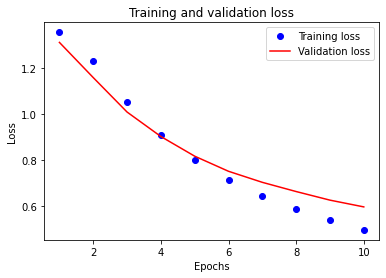

In [82]:
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, validation_loss, 'red', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

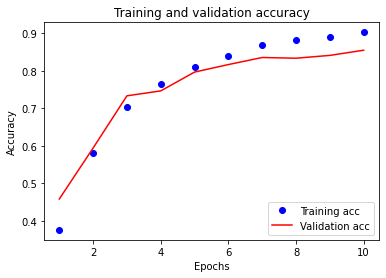

In [83]:
plt.plot(epochs, bin_acc, 'bo', label='Training acc')
plt.plot(epochs, validation_acc, 'red', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

## Model Export

In [84]:
export_model = tf.keras.Sequential([
    vectorize_layer,
    model,
    layers.Activation('sigmoid')
])

In [85]:
export_model.compile(
    loss=losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer='adam',
    metrics=['accuracy']
)

In [86]:
loss, accuracy = export_model.evaluate(raw_test_ds)

250/250 [==============================] - 2s 8ms/step - loss: 0.5584 - accuracy: 0.8575


## Model Inference

In [87]:
samples = [
"""
No PHP, podemos converter uma quebra de linha para um através da função nl2br. 
E no JavaScript? Como posso fazer isso de maneira segura?Decidi fazer a pergunta porque não sei 
se um simples replace(\n") cabe para todos os casos de quebra de linha.
""",


"""
Quando eu declaro funcionario como Pessoa no main(), para onde "vai" o valor do atributo salario, 
já que a classe Pessoa não tem esse atributo?

public abstract class Pessoa {
    private String nome;
    private Long cpf;

    public Pessoa(String nome, Long cpf) {
        this.nome = nome;
        this.cpf = cpf;
    }
}

public class Funcionario extends Pessoa {
    private float salario;
    public Funcionario(String nome, Long cpf, float salario) {
        super(nome, cpf);
        this.salario = salario;
    }
}

public class Principal {
    public static void main(String[] args) {
        Pessoa funcionario = new Funcionario("Fulano", 123L, 1000);
    }

}
""",


"""
Como usar uma função de variável várias vezes sem precisar criar outra variável? Como por exemplo sortear um número
import random
n = random.randint(1, 6)
print('O valor sorteado foi {}'.format(n))
if nd !=n:
    print('Não foi dessa vez')
if nd ==n:
    print('Parabéns! Você está com sorte')
start1 = str(input('Deseja continuar? '))
if start1 =='Sim':
    nd1 = int(input('Qual valor você deseja? De 1 até 6? '))
else: exit()
n1 = random.randint(1, 6)
print('O valor sorteado foi {}'.format(n1))
if nd1 ==n1:
    print('Parabéns! Você está com sorte')
else: print('Não foi dessa vez!')
""",


"""
 Que tipo de dado usar para armazenar data de falecimento num cadastro (DateTime ou string)?
 Tenho um cadastro de pessoas onde preciso armazenar as datas de nascimento (DateBirth) e falecimento (DateDeath). 
 Sabendo que o tipo DateTime em C# não pode ser vazio e seu valor inicial padrão é 01/01/0001 00:00:00, o que não faz sentido para o preenchimento de um campo que trata de uma data de falecimento de uma pessoa, que solução vocês aplicariam? Definiriam mesmo assim a propriedade como do tipo DateTime e fariam algum tipo de tratamento depois? Definiriam como do tipo string? Ou que outra solução sugeririam?

  public class Person
  {
      public string Name { get; set; }
      public string Gender { get; set; }
      public DateTime DateBirth { get; set; }

      // Definir a propriedade como DateTime há um valor inicial pré-definido: 01/01/0001
      // public DateTime DateDeath { get; set; }
      
      // Ou definir a propriedade como string, iniciando-a com valor vazio,
      // mas sem os recursos de validação do tipo DateTime.
      // public string DateDeath { get; set; }
  }   
"""
]

In [90]:
"""
The classes represented in the array, from left to right, are: 
C#, Java, JavaScript, Python
"""
export_model.predict(samples, verbose=1)

1/1 [==============================] - 0s 29ms/step


array([[0.47102517, 0.3422407 , 0.69729567, 0.4763867 ],
       [0.79124475, 0.9643788 , 0.11634764, 0.06753245],
       [0.20316544, 0.22341871, 0.25665855, 0.9826393 ],
       [0.9821135 , 0.54012895, 0.11644873, 0.08401725]], dtype=float32)

In [91]:
raw_train_ds.class_names

['csharp', 'java', 'javascript', 'python']